# Lecture 7 Workbook
## Regression
This is a workbook that contains the python code that was used in slides
appearing in the lecture. It is provided so that you can see for yourself
how this code works.

## Definitions and setup
Code here is just for making everything look sort of *uniform*

In [61]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from scipy.stats import gamma, norm, t, randint, chi2, poisson, multivariate_normal
from scipy.stats import ttest_ind
import pandas as pd
from IPython.display import HTML


In [62]:
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10

This is the seed for the random number generator. Graphs for the course will be generated with seed 367 (for BME). You can change it or use 'shuffle' to get different pseudo-random numbers each time.

In [63]:
np.random.seed(367)

## Load data
Load data on cerebellar volumes

In [64]:
cblm_data = pd.read_csv('cerebellar_volumes.csv')


## Correlations

### Pitman correlation

#### Show height and weight for 6 people

Text(0, 0.5, 'Weight (kg)')

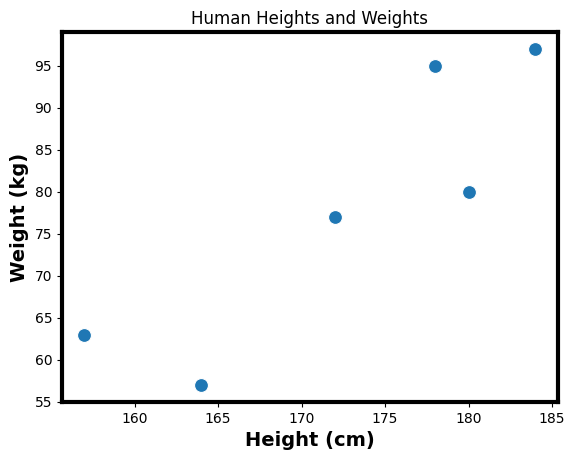

In [65]:
# Create a dictionary with heights and weights
data = {
    'Height': [157, 164, 180, 178, 184, 172],
    'Weight': [63, 57, 80, 95, 97, 77]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Plotting using Seaborn
sns.scatterplot(x='Height', y='Weight', data=df)
plt.title('Human Heights and Weights')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

#### Demonstrate correlated variables


In [66]:
def generate_correlated_height_and_weight(correlation):
  # Set the mean and covariance matrix for the bivariate distribution
  mean = [170, 65]  # Mean height and weight
  std_height = 10  # Standard deviation of height
  std_weight = 10  # Standard deviation of weight

  cov_matrix = [[std_height**2, correlation * std_height * std_weight],
   [correlation * std_height * std_weight, std_weight**2]]

  # Generate random samples from the bivariate distribution
  samples = multivariate_normal.rvs(mean=mean, cov=cov_matrix, size=50)
  return samples


Text(0, 0.5, 'Weight (kg)')

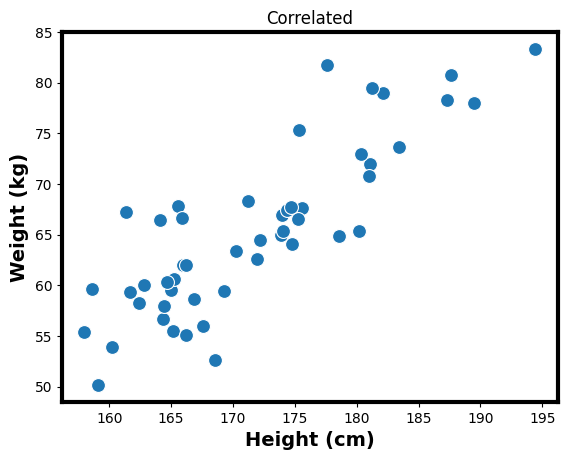

In [67]:
samples = generate_correlated_height_and_weight(0.9)
# Create a DataFrame from the generated data
data = {'Height': samples[:, 0], 'Weight': samples[:, 1]}
df = pd.DataFrame(data)

# Plotting using Seaborn
sns.scatterplot(x='Height', y='Weight', data=df)
plt.title('Correlated')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

#### Demonstrate anti-correlated variables

Text(0, 0.5, 'Weight (kg)')

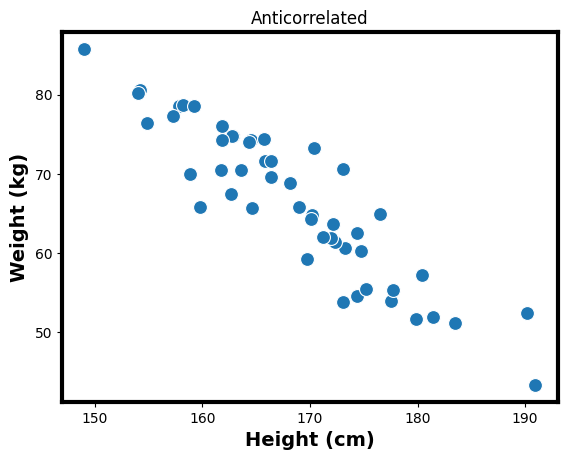

In [68]:
samples = generate_correlated_height_and_weight(-0.9)
# Create a DataFrame from the generated data
data = {'Height': samples[:, 0], 'Weight': samples[:, 1]}
df = pd.DataFrame(data)

# Plotting using Seaborn
sns.scatterplot(x='Height', y='Weight', data=df)
plt.title('Anticorrelated')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

#### Demonstrate uncorrelated variables

Text(0, 0.5, 'Weight (kg)')

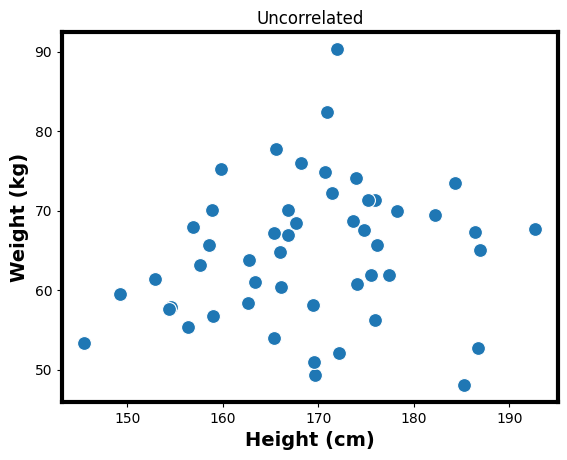

In [69]:
samples = generate_correlated_height_and_weight(0.0)
# Create a DataFrame from the generated data
data = {'Height': samples[:, 0], 'Weight': samples[:, 1]}
df = pd.DataFrame(data)

# Plotting using Seaborn
sns.scatterplot(x='Height', y='Weight', data=df)
plt.title('Uncorrelated')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

#### Correlation of 1.0

Text(0, 0.5, 'Weight (kg)')

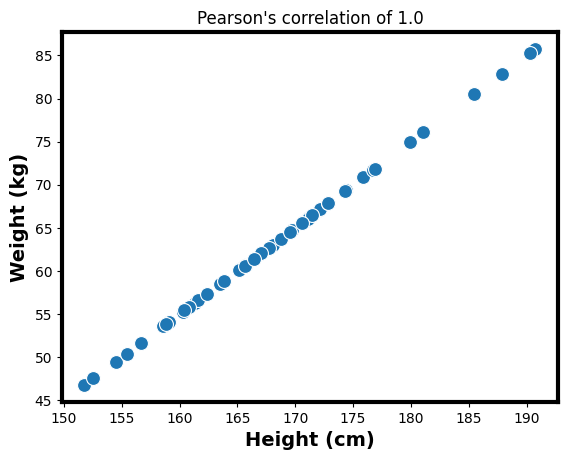

In [70]:
samples = generate_correlated_height_and_weight(1.0)
# Create a DataFrame from the generated data
data = {'Height': samples[:, 0], 'Weight': samples[:, 1]}
df = pd.DataFrame(data)

# Plotting using Seaborn
sns.scatterplot(x='Height', y='Weight', data=df)
plt.title("Pearson's correlation of 1.0")
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

#### Correlation of -1.0

Text(0, 0.5, 'Weight (kg)')

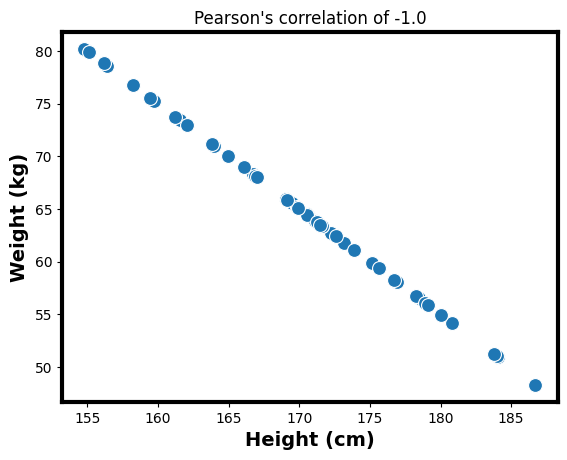

In [71]:
samples = generate_correlated_height_and_weight(-1.0)
# Create a DataFrame from the generated data
data = {'Height': samples[:, 0], 'Weight': samples[:, 1]}
df = pd.DataFrame(data)

# Plotting using Seaborn
sns.scatterplot(x='Height', y='Weight', data=df)
plt.title("Pearson's correlation of -1.0")
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

## The bivariate population model

### Scatterplot of bivariate data

Text(0, 0.5, 'Cerebellar Volume (% of TICV)')

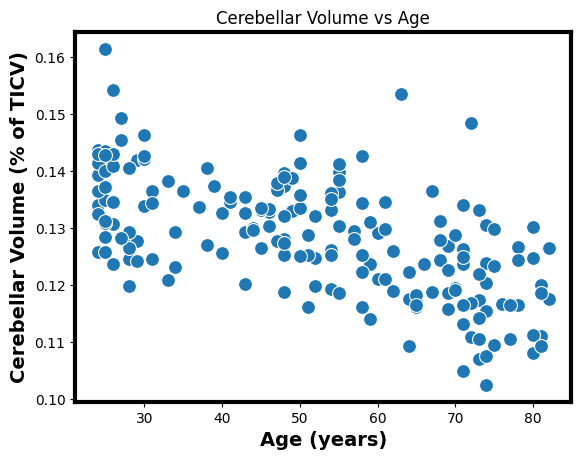

In [72]:
# Filter data where age is between 24 and 82
filtered_data = cblm_data[(cblm_data['Age'] >= 24) & (cblm_data['Age'] <= 82)]

# Plotting using Seaborn
sns.scatterplot(x='Age', y='TCV_Corr', data=filtered_data)
plt.title('Cerebellar Volume vs Age')
plt.xlabel('Age (years)')
plt.ylabel('Cerebellar Volume (% of TICV)')

## Solving for the regression coefficients

### Functions to calculate estimators for regerssion parameters

In [73]:
import numpy as np

def calc_b1(X, Y):
    """
    Calculate the coefficient b1 in the linear regression equation.

    Args:
        X (ndarray): Input array of predictor variable.
        Y (ndarray): Input array of response variable.

    Returns:
        float: Coefficient b1.
    """
    numerator = (X.shape[0] * np.sum(X * Y)) - (np.sum(X) * np.sum(Y))
    denominator = (X.shape[0] * np.sum(X**2)) - (np.sum(X)**2)
    b1 = numerator / denominator
    return b1

def calc_b0(X, Y):
    """
    Calculate the coefficient b0 in the linear regression equation.

    Args:
        X (ndarray): Input array of predictor variable.
        Y (ndarray): Input array of response variable.

    Returns:
        float: Coefficient b0.
    """
    b1 = calc_b1(X, Y)
    b0 = np.mean(Y) - b1 * np.mean(X)
    return b0

def calc_yhat(X, b0, b1):
    """
    Calculate the predicted values (Yhat) based on the linear regression equation.

    Args:
        X (ndarray): Input array of predictor variable.
        b0 (float): Coefficient b0.
        b1 (float): Coefficient b1.

    Returns:
        ndarray: Predicted values (Yhat).
    """
    Yhat = b1 * X + b0
    return Yhat

def calc_syx(X, Y, b0, b1):
    """
    Calculate the standard error of the estimate (SYX) for linear regression.

    Args:
        X (ndarray): Input array of predictor variable.
        Y (ndarray): Input array of response variable.
        b0 (float): Coefficient b0.
        b1 (float): Coefficient b1.

    Returns:
        float: Standard error of the estimate (SYX).
    """
    residuals = Y - calc_yhat(X, b0, b1)
    syx = np.sum(residuals**2) / (X.shape[0] - 2)
    return syx


### Showing the regression fit

Text(0, 0.5, 'Cerebellar Volume (% of TICV)')

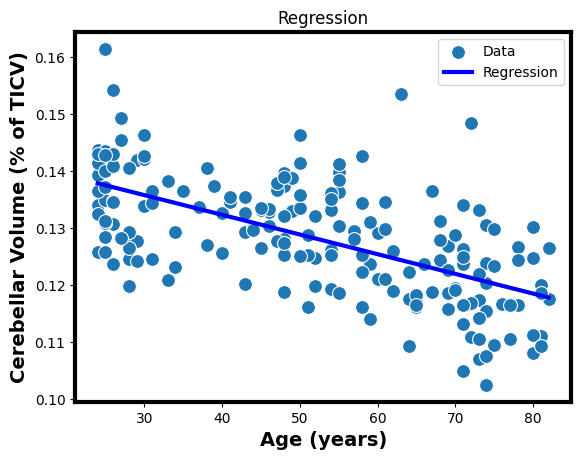

In [74]:
# Plotting using Seaborn
sns.scatterplot(x='Age', y='TCV_Corr', data=filtered_data, label='Data')

# Calculate regression line coefficients
b1 = calc_b1(filtered_data['Age'], filtered_data['TCV_Corr'])
b0 = calc_b0(filtered_data['Age'], filtered_data['TCV_Corr'])

# Add regression line
x_range = np.linspace(filtered_data['Age'].min(), filtered_data['Age'].max(), 100)
y_range = calc_yhat(x_range, b0, b1)
plt.plot(x_range, y_range, color='blue', label='Regression')

plt.legend()

# Set plot labels and title
plt.title('Regression')
plt.xlabel('Age (years)')
plt.ylabel('Cerebellar Volume (% of TICV)')


### Showing what a residual is

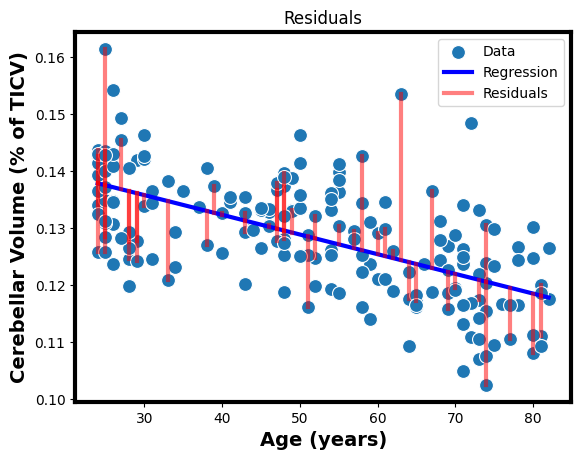

In [75]:
# Plotting using Seaborn
sns.scatterplot(x='Age', y='TCV_Corr', data=filtered_data, label='Data')

# Calculate regression line coefficients
b1 = calc_b1(filtered_data['Age'], filtered_data['TCV_Corr'])
b0 = calc_b0(filtered_data['Age'], filtered_data['TCV_Corr'])

# Add regression line
x_range = np.linspace(filtered_data['Age'].min(), filtered_data['Age'].max(), 100)
y_range = calc_yhat(x_range, b0, b1)
plt.plot(x_range, y_range, color='blue', label='Regression')

# Calculate residuals
residuals = filtered_data['TCV_Corr'] - calc_yhat(filtered_data['Age'], b0, b1)
x_coords = filtered_data['Age']
y_coords = filtered_data['TCV_Corr']

# Select 10 elements from the zip output
n_lines = 50
# Add red lines connecting the selected residuals
for x, y, res in islice(zip(x_coords, y_coords, residuals), n_lines):
    plt.plot([x, x], [y, y - res], 'r-', alpha=0.5, label="Residuals")

# Make a legend skipping the duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Set plot labels and title
plt.title('Residuals')
plt.xlabel('Age (years)')
plt.ylabel('Cerebellar Volume (% of TICV)')

plt.show()


### Create an interactive widget to show how residuals correlate with model

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider

def generate_data():
    np.random.seed(0)
    x = np.linspace(-10, 10, 100)
    y = 2 * x + np.random.normal(0, 3, len(x))
    return x, y

x, y = generate_data()

def calculate_residuals(slope):
    # Calculate regression line parameters
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    slope_regression = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)

    # Calculate residuals
    residuals = y - (slope * x + y_mean - slope_regression * x_mean)
    sum_squared_residuals = np.sum(residuals**2)

    return residuals, sum_squared_residuals

def calculate_regression(slope):
    # Calculate regression line parameters
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    slope_regression = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)

    # Plot regression line with modified slope
    y_regression = slope * x + y_mean - slope_regression * x_mean
    return y_regression


def calculate_correlation(slope):
    # Get residuals
    residuals, ss_residuals = calculate_residuals(slope)
    y_regression = calculate_regression(slope)
    return np.corrcoef(residuals, y_regression)[0, 1]

slope_min = 0.5
slope_max = 3.5
slope_range = np.linspace(slope_min, slope_max, 100)
sum_squared_residuals = [calculate_residuals(s)[1] for s in slope_range]
correlation_residual_y_regression = [calculate_correlation(s) for s in slope_range]



def plot_line_with_scatter(slope):
    x, y = generate_data()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 8))

    # Plot scatter plot and regression line
    ax1.scatter(x, y, label='Data')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    # Calculate regression line parameters
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    slope_regression = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)

    # Plot regression line with modified slope
    y_regression = slope * x + y_mean - slope_regression * x_mean
    ax1.plot(x, y_regression, color='red', label='Regression Line')
    
    ax1.set_title(f'Slope = {slope:.2f}')
    ax1.legend()
    ax1.grid(True)

    # Plot residuals
    residuals = y - (slope * x + y_mean - slope_regression * x_mean)
    ax2.scatter(x, residuals, label='Residuals')
    ax2.axhline(0, color='black', linestyle='--')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Residuals')
    ax2.grid(True)

    # Plot sum squared residuals vs. slope
    ax3.plot(slope_range, sum_squared_residuals, label='Sum Squared Residuals')
    ax3.scatter(slope, calculate_residuals(slope)[1], color='red', s=100, label='Current Slope')
    ax3.set_xlabel('Slope')
    ax3.set_ylabel('Sum Squared Residuals')
    ax3.legend()
    ax3.grid(True)

    ax4.plot(slope_range, correlation_residual_y_regression, label='Correlation')
    ax4.scatter(slope, calculate_correlation(slope), color='red', s=100, label='Current Slope')
    ax4.set_xlabel('Slope')
    ax4.set_ylabel('Correlation')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

slope_slider = FloatSlider(min=slope_min, max=slope_max, step=0.1, value=2.8, description='Slope')
interactive_plot = interactive(plot_line_with_scatter, slope=slope_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot


interactive(children=(FloatSlider(value=2.8, description='Slope', max=3.5, min=0.5), Output(layout=Layout(heig…

## Plotting multivariate data

Text(0, 0.5, 'Cerebellar Volume (cc)')

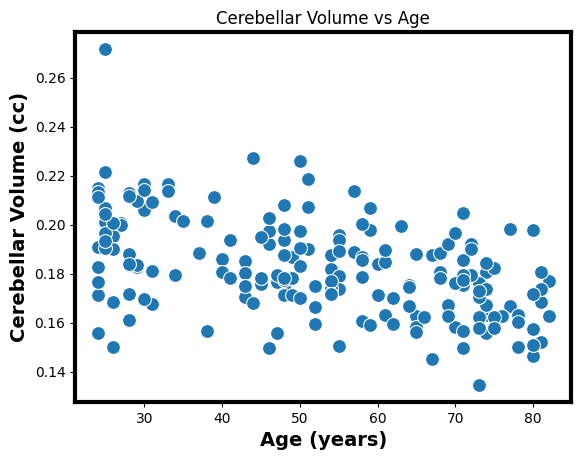

In [77]:
sns.scatterplot(x='Age', y='TCV', data=filtered_data)
plt.title('Cerebellar Volume vs Age')
plt.xlabel('Age (years)')
plt.ylabel('Cerebellar Volume (cc)')

Text(0, 0.5, 'Cerebellar Volume (cc)')

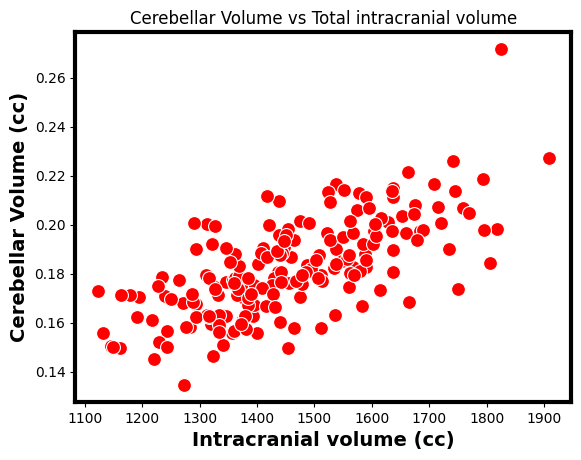

In [78]:
sns.scatterplot(data=filtered_data, x="eTIV", y="TCV", color="r")
plt.title('Cerebellar Volume vs Total intracranial volume')
plt.xlabel('Intracranial volume (cc)')
plt.ylabel('Cerebellar Volume (cc)')

Text(0, 0.5, 'Cerebellar Volume (cc)')

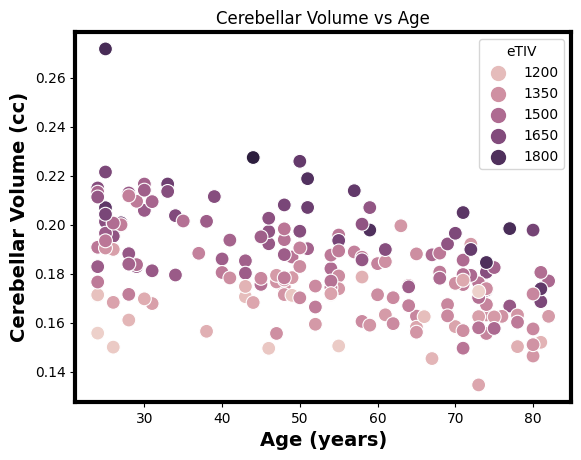

In [79]:
sns.scatterplot(x='Age', y='TCV', hue='eTIV', data=filtered_data)
plt.title('Cerebellar Volume vs Age')
plt.xlabel('Age (years)')
plt.ylabel('Cerebellar Volume (cc)')

Text(0, 0.5, 'Cerebellar Volume (cc)')

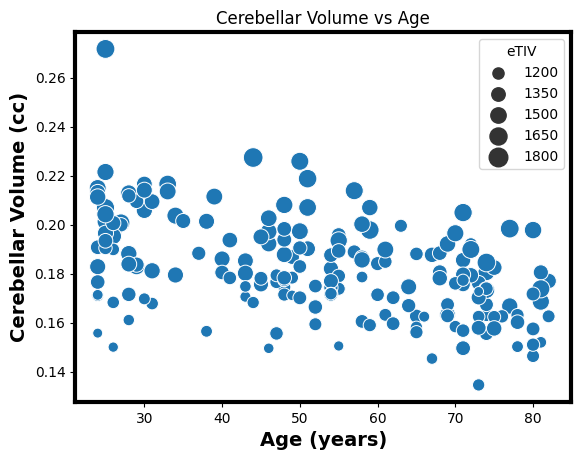

In [80]:
sns.scatterplot(x='Age', y='TCV', size='eTIV', data=filtered_data)
plt.title('Cerebellar Volume vs Age')
plt.xlabel('Age (years)')
plt.ylabel('Cerebellar Volume (cc)')

Text(0, 0.5, 'Age (years)')

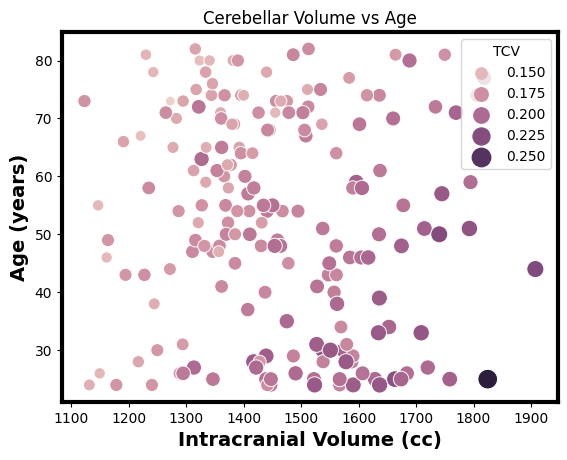

In [81]:
sns.scatterplot(x='eTIV', y='Age', hue='TCV', size='TCV', data=filtered_data)
plt.title('Cerebellar Volume vs Age')
plt.xlabel('Intracranial Volume (cc)')
plt.ylabel('Age (years)')


Text(0.5, 0, 'Cerebellar volume (cc)')

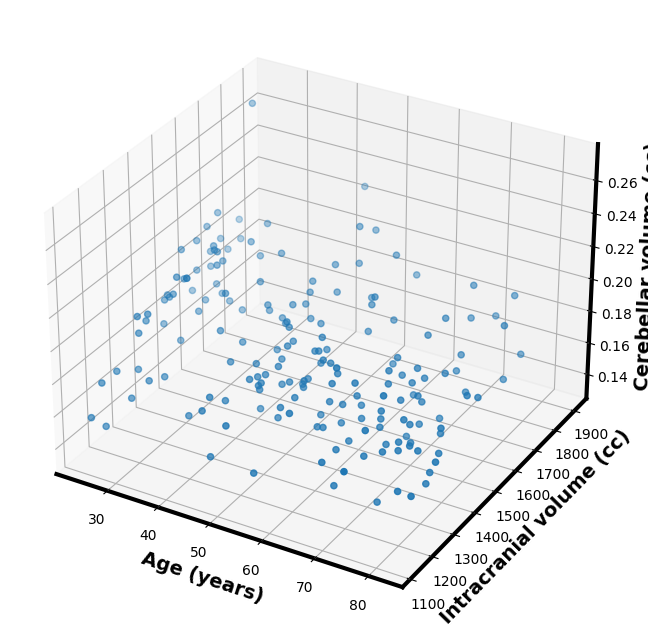

In [82]:
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered_data['Age'], filtered_data['eTIV'], filtered_data['TCV'])
ax.set_xlabel('Age (years)')
ax.set_ylabel('Intracranial volume (cc)')
ax.set_zlabel('Cerebellar volume (cc)')



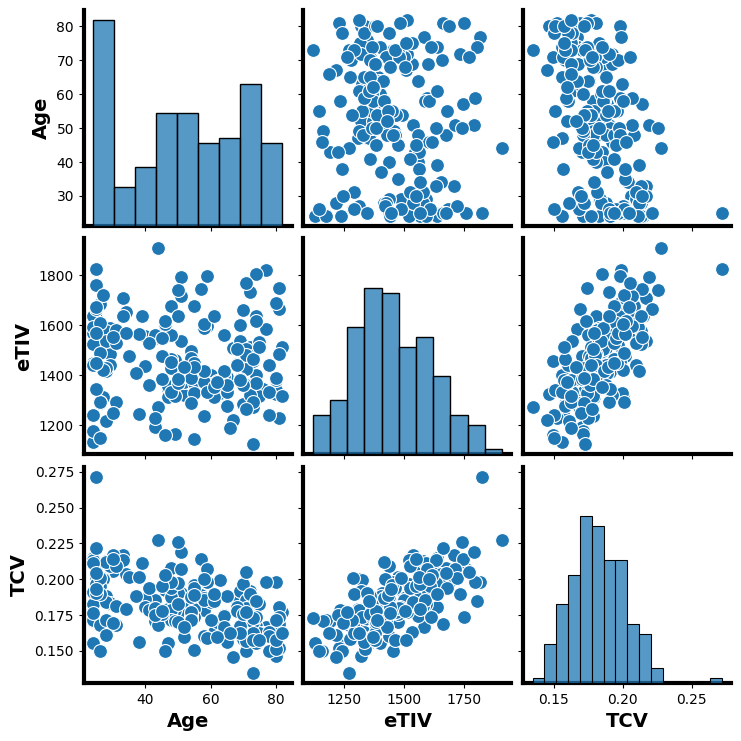

In [83]:
sns.pairplot(data=filtered_data, vars=["Age", "eTIV", "TCV"])

## Generalizing the population model

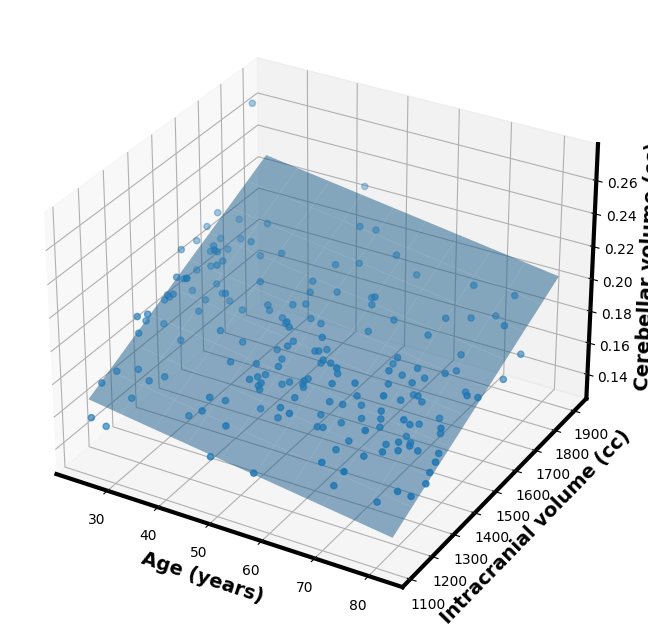

In [85]:
# Extract the data
x = filtered_data['Age']
y = filtered_data['eTIV']
z = filtered_data['TCV']

# Prepare the design matrix
X = np.column_stack((np.ones_like(x), x, y))

# Calculate the regression coefficients
XTX_inv = np.linalg.inv(X.T @ X)
coefficients = XTX_inv @ X.T @ z

# Generate the grid for the plane
age_range = np.linspace(min(x), max(x), 10)
etiv_range = np.linspace(min(y), max(y), 10)
age_grid, etiv_grid = np.meshgrid(age_range, etiv_range)
plane = coefficients[0] + coefficients[1] * age_grid + coefficients[2] * etiv_grid

# Plot the scatter points
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel('Age (years)')
ax.set_ylabel('Intracranial volume (cc)')
ax.set_zlabel('Cerebellar volume (cc)')

# Plot the regression plane
ax.plot_surface(age_grid, etiv_grid, plane, alpha=0.5)